# Computer vision 

## Agenda



* frequency domain image,
* image analysis in the frequency domain,
* high-pass and low-pass filtering,
* optimization of the filtering process by convolution operation using the frequency domain

## Helpers

To perform the tasks, it is necessary to import the libraries used in the script and download the data on which we will be working.

In this script we will be using:
*  Image Lenna (available at the [link](http://www.lenna.org/)) - one of the most popular images historically used for testing image processing and compression,

In [1]:
# importing of libraires that will be use in the script
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd
import json
import os

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# download Lenna image
!wget -O lena_std.tif http://www.lenna.org/lena_std.tif

--2022-11-06 14:39:48--  http://www.lenna.org/lena_std.tif
Resolving www.lenna.org (www.lenna.org)... 107.180.37.106
Connecting to www.lenna.org (www.lenna.org)|107.180.37.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena_std.tif’

lena_std.tif        100%[===================>] 768.14K   525KB/s    in 1.5s    

2022-11-06 14:39:50 (525 KB/s) - ‘lena_std.tif’ saved [786572/786572]



The colab platform requires a special way to display images with opencv. If the notebook is run in collab, execute the following code:

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
      if a.shape[2] == 4:
        a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
      else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

In [4]:
def h_color(a, interpolation=None, size=None, fy=1.5, fx=1.5, cmap='gray'):
  s = [int(a.shape[0] * fy), int(a.shape[1] * fx)] if size is None else size
  plt.figure(figsize=s)
  plt.tick_params(
    axis='both', which='both',
    bottom=False, top=False,
    labelbottom=False, labelleft=False, left=False, right=False
  )
  plt.imshow(a, cmap=cmap, interpolation=interpolation)

In [5]:
css = """
<style type="text/css">
  table, td, table.dataframe, table.dataframe td { 
    border: 1px solid black;    //border: double;
    border-collapse: collapse;
    border-style: solid;
    border-spacing: 0px;
    background-color: rgb(250,250,250);
    width: 24px;
    height: 24px;
    text-align: center;
    transform: scale(1.0);
    margin: 5px;
    }
</style>
"""

def h(s):
   return display(HTML(css + DataFrame(s).to_html(header=False, index=False)))

In [6]:
def h_color_3d(z):
  fig = go.Figure(data=[go.Surface(z=z)])
  fig.update_layout(autosize=False, width=500, height=500)
  fig.show()

# Image in the frequency domain

Previous examples of image processing dealt with the domain of intensity. Another area where an image can be represented is **frequency**. The frequency domain image should be viewed as information about which pixels contain some frequently repeating pattern and which are little repeating patterns.

For example, an image that is very blurry will have a lot of repeating fragments (blur is a kind of repeating function). However, a very sharp image will have much less such patterns (because neighboring pixels will be very different from each other).

An example of the transition from the intensity domain to the frequency domain is shown below.


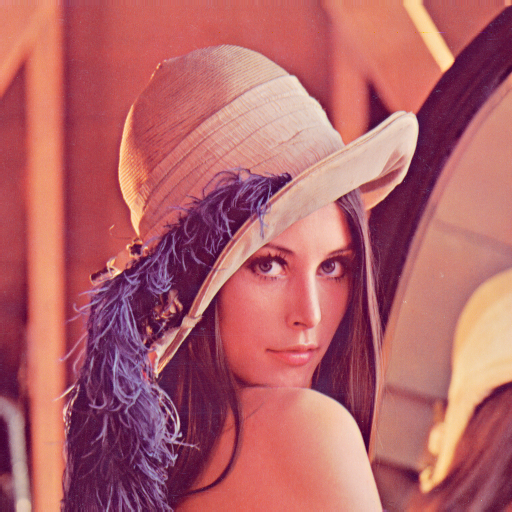

In [7]:
img = cv2.imread('./lena_std.tif', 1)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(img)

### Fourier transform

The Fourier transform is given by the following formula:

$${\mathcal{F}}(\omega) = \int_{-\infty}^{\infty} f(x) e^{-2\pi i x \omega} dx$$

for 2d signal:

$${\mathcal{F}}(u,v) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x,y) e^{-2\pi i (ux+vy)} dx dy$$

Where $u,v$ are frequencies, $ f (x,y) $ is an image on an intensity scale, $ i ^ 2 = -1 $ - an imaginary number. The above formula can be interpreted as follows:


*  ${\mathcal{F}}(u,v) $ it is performed for each frequency,
* for each $ {\mathcal {F}} (u,v) $, the input image is multiplied by the component given in the formula (with the corresponding $ u,v $) and the resultant summed. It can also be treated as a weighted sum of each pixel, where the weight is the component given in the formula,


The transformation from the intensity domain to the frequency domain is performed using the Fourier transform, which is implemented in OpenCV or NumPy. An example of using the NumPy library is presented below.

The **fft2** function performs a Fourier Transform for 2-dimensional signals. Then, using the **fftshift** function, we shift the data in such a way that the pixels corresponding to the **high frequencies** are closer to the center and the **low frequency** pixels at the edges of the image (in the frequency domain).




In [8]:
f = np.fft.fft2(img_grayscale)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))

The inverse transform comes down to performing an inverse pixel shift and performing the operation **ifft2**, which results in an image in the intensity domain (it is necessary to take the real part by **real()**, because the result is in a complex form).

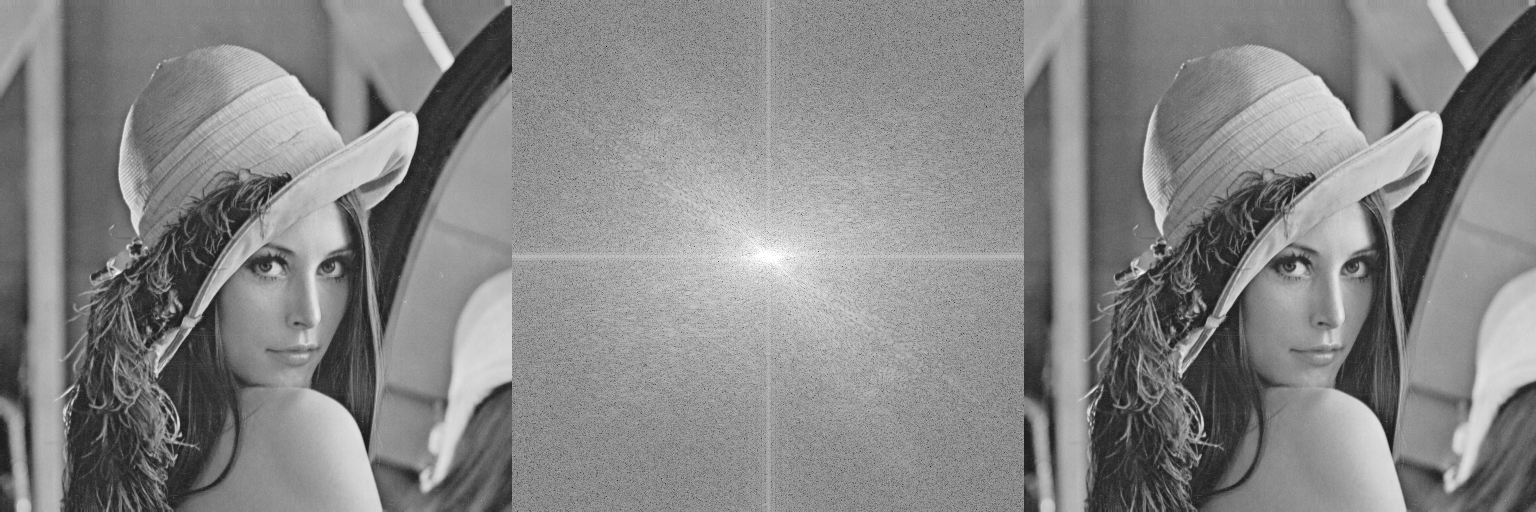

In [9]:
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)

imshow(np.concatenate([img_grayscale, magnitude_spectrum, img_back], 1))

## Interpretation of the frequency domain

Having the inverse transform (frequency -> intensity), we can do a few experiments to approximate the relationship between pixel values in the frequency domain and the intensity.

In [10]:
def get_mask(s, div):
    mask = np.zeros(s, np.float32)
    return cv2.circle(mask,(s[0]//2, s[1]//2), s[0]//div, 1, -1)

def fft(img, size=None):
    f = np.fft.fft2(img, size)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift))
    return fshift, spectrum

def ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    return np.real(img_back)

def showFreqAndImages(frequencies, images):
  fig, axes = plt.subplots(2,len(frequencies),figsize=(20,10))
  for i, (freq, img) in enumerate(zip(frequencies,images)):
    axes[0,i].imshow(freq,cmap='gray', vmin=0, vmax=255)
    axes[1,i].imshow(img,cmap='gray', vmin=0, vmax=255)
  plt.show()

Let's define an image (256 x 256) filled with all zeros with high values set at certain positions. These coordinates will be respectively (where $S_h = height / 2 = 128$ and $S_w = width / 2 = 128$):

* $(S_h, S_w)$
* $(S_h, S_w - 1)$
* $(S_h, S_w + 1)$
* $(S_h, S_w - 1)$, $(S_h, S_w + 1)$

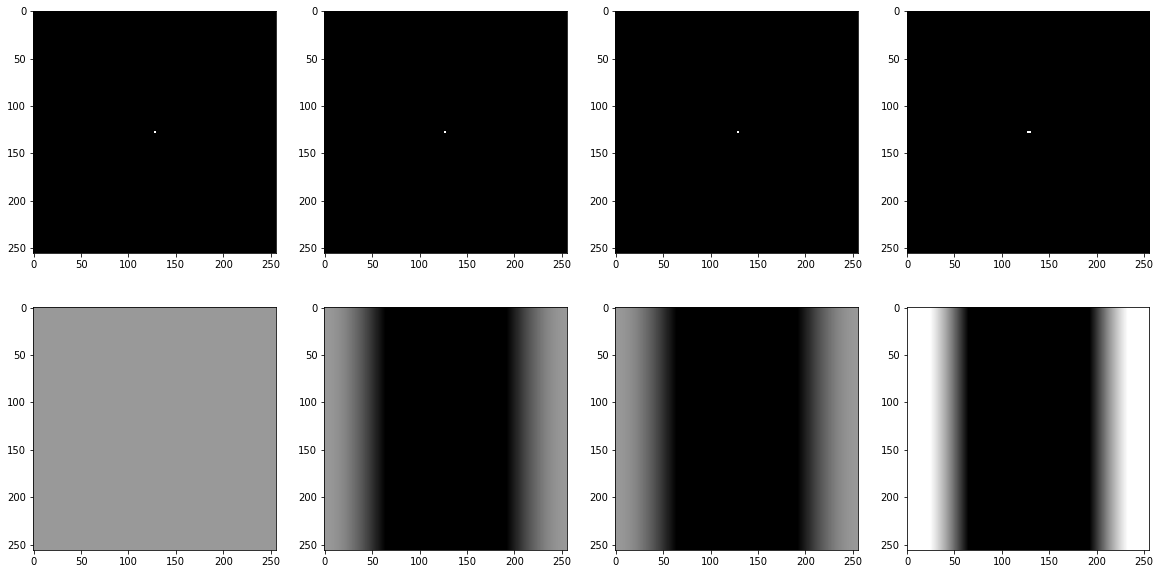

In [11]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh, sw] = 10000000.0

freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh, sw - 1] = 10000000.0

freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh, sw + 1] = 10000000.0

freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh, sw - 1] = 10000000.0
freq_4[sh, sw + 1] = 10000000.0


img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)


showFreqAndImages([freq_1, freq_2, freq_3, freq_4], [img_i_1, img_i_2, img_i_3, img_i_4])



Similarly, for changing pixel values vertically:
* $(S_h, S_w)$
* $(S_h - 1, S_w)$
* $(S_h + 1, S_w)$
* $(S_h - 1, S_w)$, $(S_h + 1, S_w)$

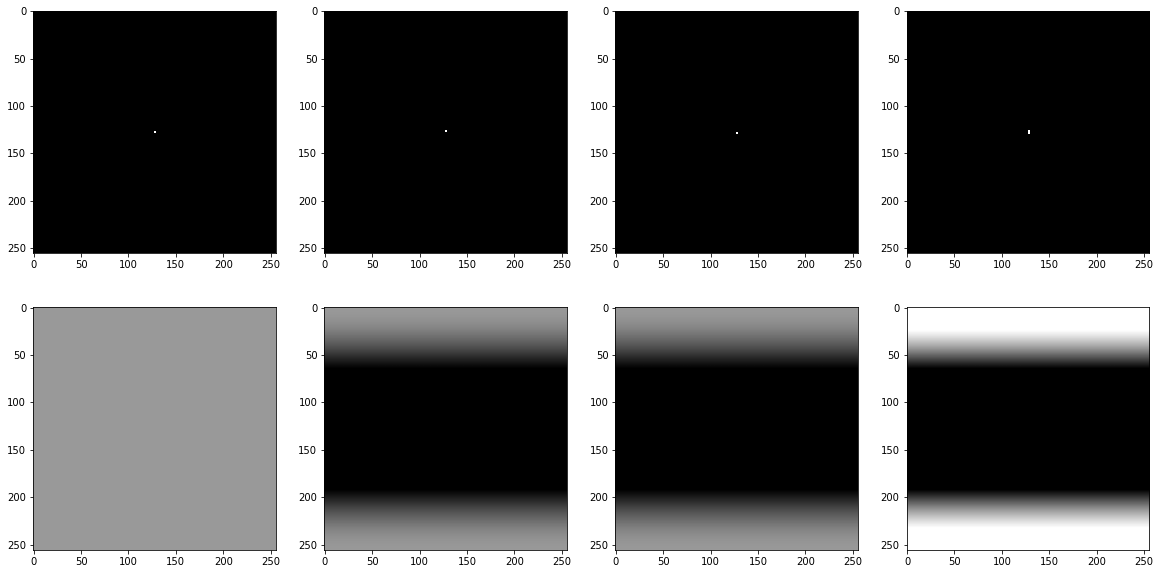

In [12]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh, sw] = 10000000.0
freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh - 1, sw] = 10000000.0
freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh + 1, sw] = 10000000.0
freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh - 1, sw] = 10000000.0
freq_4[sh + 1, sw] = 10000000.0


img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)

showFreqAndImages([freq_1, freq_2, freq_3, freq_4], [img_i_1, img_i_2, img_i_3, img_i_4])

The above experiment provides the following conclusions:
* the middle pixel corresponds to a uniform image (frequency equal to zero),
* pixels deflected by 1 to the left and right represent the same results because they correspond to signals with opposite frequencies),
* the horizontal changes correspond to the 2D horizontal signals in the image in the intensity domain; similarly for vertical changes.




By setting high values further from the center, the inverse Fourier transform operation will create intensity-domain images containing signals of higher frequency.

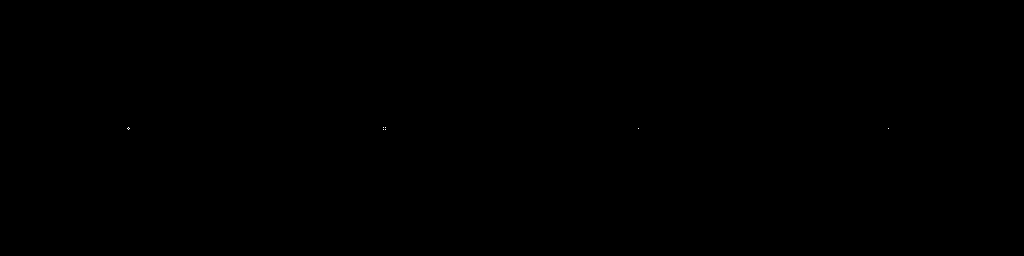

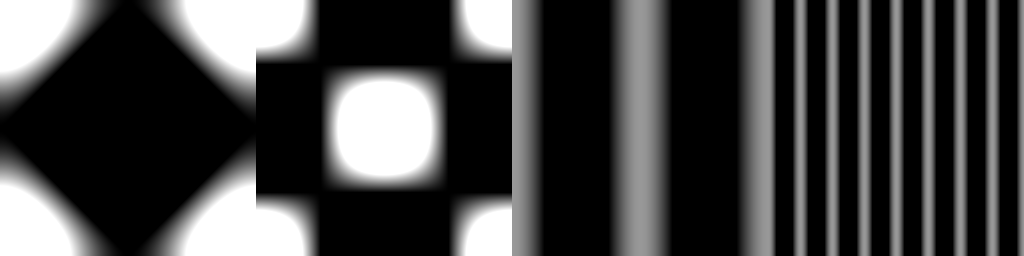

In [13]:
sw = 256 // 2
sh = 256 // 2

freq_1 = np.zeros([256, 256], np.float32)
freq_1[sh - 1, sw] = 10000000.0
freq_1[sh + 1, sw] = 10000000.0
freq_1[sh, sw - 1] = 10000000.0
freq_1[sh, sw + 1] = 10000000.0
freq_2 = np.zeros([256, 256], np.float32)
freq_2[sh - 1, sw - 1] = 10000000.0
freq_2[sh + 1, sw + 1] = 10000000.0
freq_2[sh - 1, sw + 1] = 10000000.0
freq_2[sh + 1, sw - 1] = 10000000.0
freq_3 = np.zeros([256, 256], np.float32)
freq_3[sh, sw - 2] = 10000000.0
freq_4 = np.zeros([256, 256], np.float32)
freq_4[sh, sw - 8] = 10000000.0

img_i_1 = ifft(freq_1)
img_i_2 = ifft(freq_2)
img_i_3 = ifft(freq_3)
img_i_4 = ifft(freq_4)

imshow(np.concatenate([freq_1, freq_2, freq_3, freq_4], 1))
imshow(np.concatenate([img_i_1, img_i_2, img_i_3, img_i_4], 1))

## Operations in the frequency domain

Image processing in the frequency domain is closely related to the concept of intensity convolution. According to the theorem resulting from the Fourier transform ([link](https://en.wikipedia.org/wiki/Convolution_theorem)) we can write:


$$(f \bullet g)(t) = {\mathcal{F}}^{-1}\{F * G\}$$

where:
* $f$, $F$ - input image in the intensity and frequency domains, respectively,
* $g$, $G$ - kernel / filter (e.g. Laplasjan) in intensity and frequency domains, respectively,
* ${\mathcal{F}^{-1}}$ - inverse Fourier transform
* $\bullet$ - convolution
* $*$ - multiplication

The above theory says that the operation of the convolution of two functions in the domain of time or space is equivalent to the operation of multiplication (element-wise) of their representation in the frequency space.


Earlier transformations between the domains showed that an image of a certain size (in the intensity domain) would have the same size in the frequency domain. The size directly affects the number of maximum frequencies, hence, in order to present an image of a smaller size in a greater number of frequencies, the image can be completed (as in the case of convolution) with only zeros.

When using the OpenCV implementation, you need to do it manually, while when implementing NumPy, you just need to add the size information as the second parameter of the fft2 function.



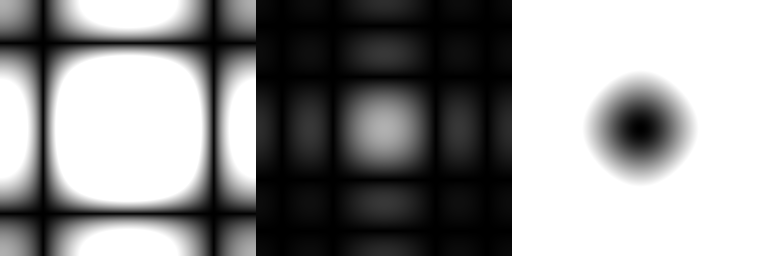

In [14]:
mean_filter = np.ones((3,3))

x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

laplacian = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])


filters = [mean_filter, gaussian, laplacian]
fft_filters = [np.fft.fft2(x, (256, 256)) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

imshow(np.concatenate(mag_spectrum, 1) * 255)



Having images in the same domain defined by the same number of frequencies, according to the theory cited, we can perform the equivalent of the convolution operation using simple multiplication in the frequency domain.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


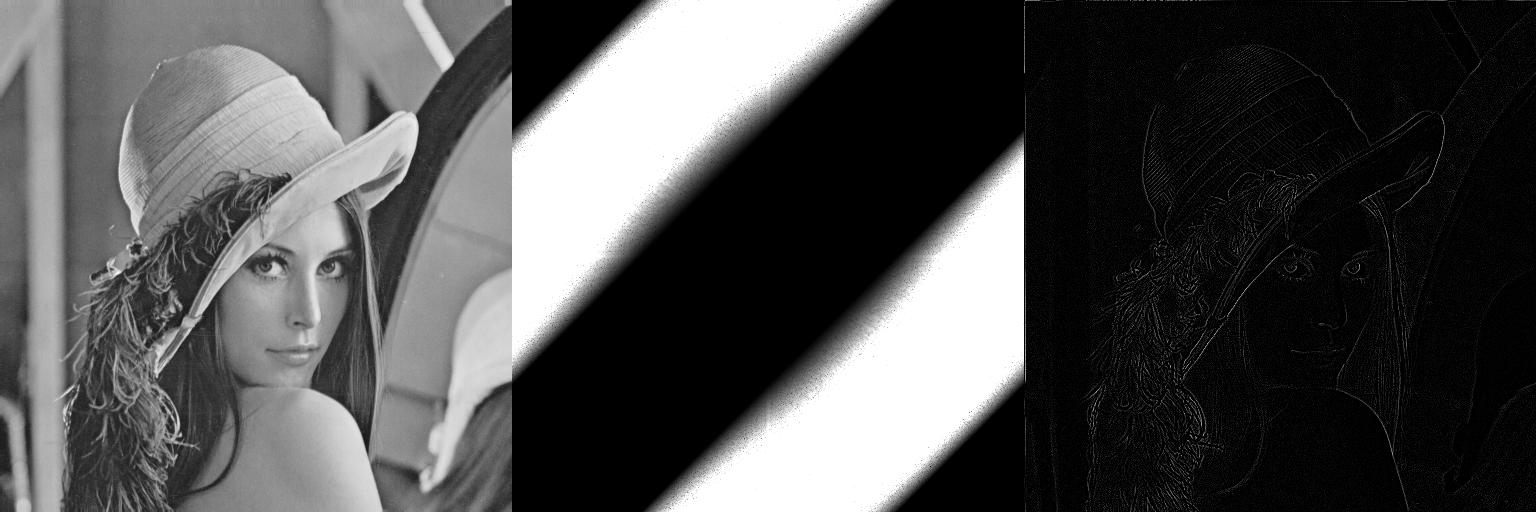

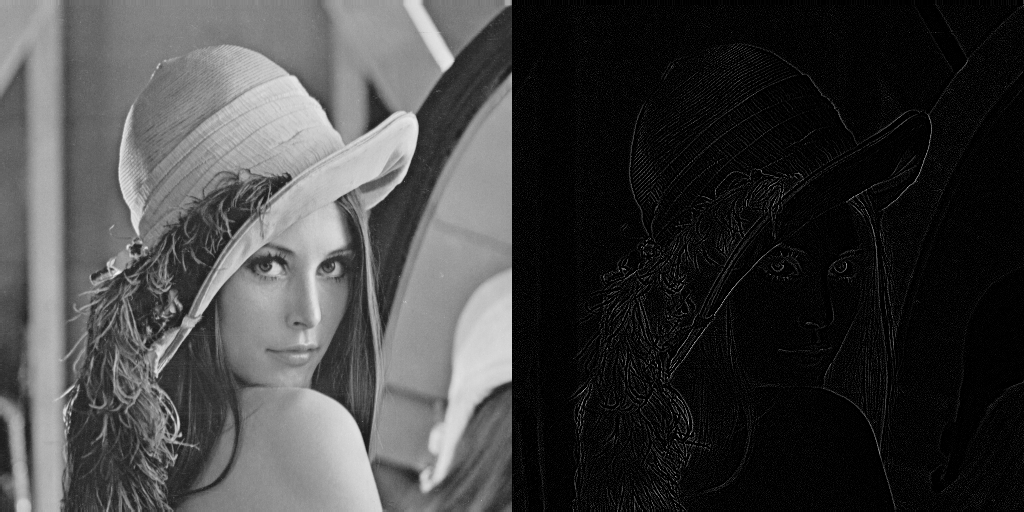

In [15]:

laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])


f_lap_shift, f_lap_mag = fft(laplacian, (512, 512))
fshift, spectrum = fft(img_grayscale)
img_i = np.real(ifft(fshift * f_lap_shift))

imshow(np.concatenate([img_grayscale, np.real(spectrum * f_lap_shift), img_i], 1))

img_i = cv2.filter2D(img_grayscale, -1, laplacian)
imshow(np.concatenate([img_grayscale, img_i], 1))

### Low Pass Filter

Frequency domain filtering can also be divided into low pass and high pass.

Low-pass filtering is one that passes low-frequency signals through and cuts the signals above a certain threshold. As you know, high-frequency signals are at the edges of the image, and the closer to the center, the lower the frequency of the signals.

The low-pass filtering implemented as the cut-off point is shown below.


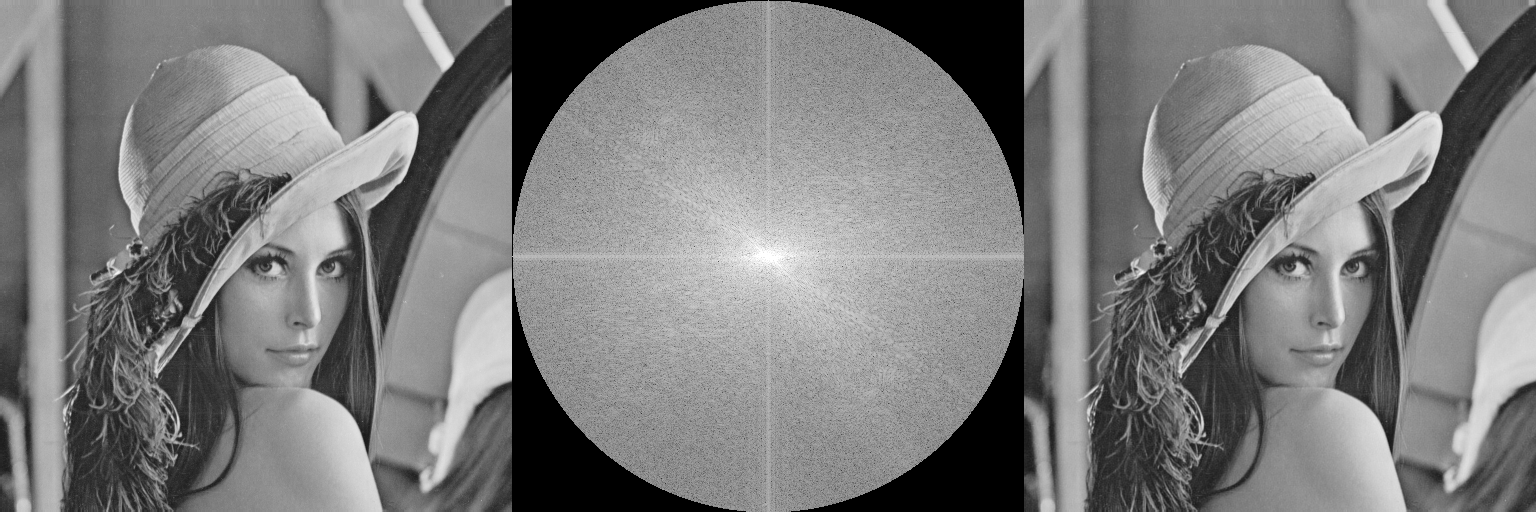

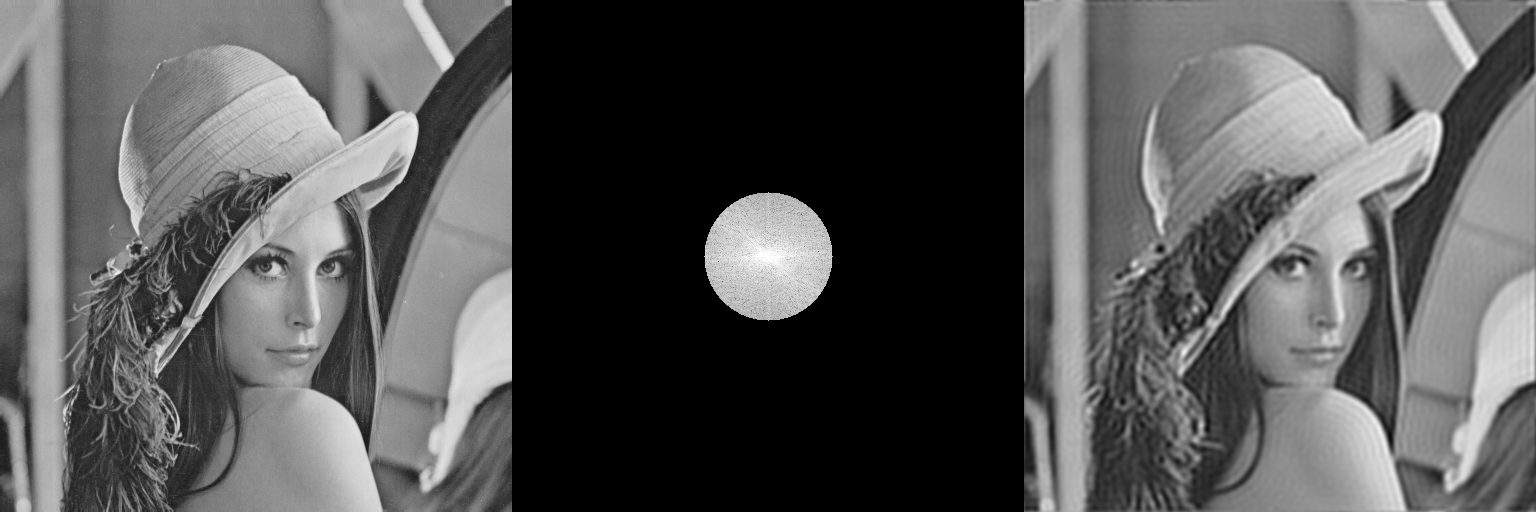

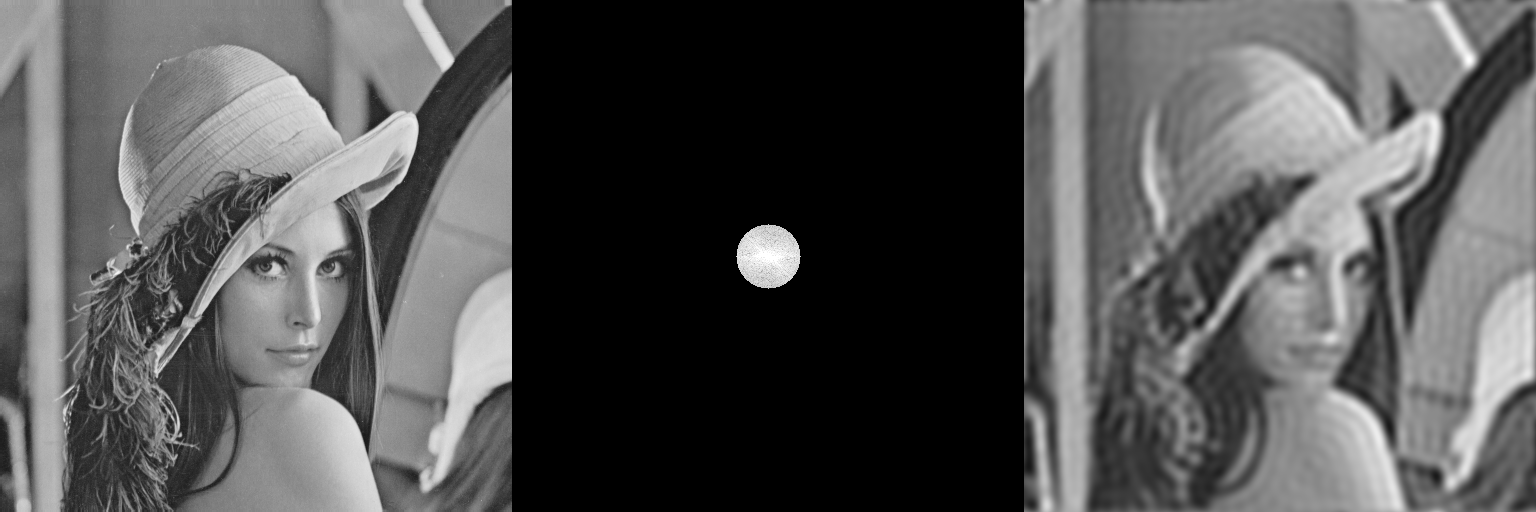

In [16]:
m1 = get_mask(img_grayscale.shape, 2)
m2 = get_mask(img_grayscale.shape, 8)
m3 = get_mask(img_grayscale.shape, 16)

fshift, spectrum = fft(img_grayscale)

img_back_1 = ifft(fshift * m1)
img_back_2 = ifft(fshift * m2)
img_back_3 = ifft(fshift * m3)

imshow(np.concatenate([img_grayscale, spectrum * m1, img_back_1], 1))
imshow(np.concatenate([img_grayscale, spectrum * m2, img_back_2], 1))
imshow(np.concatenate([img_grayscale, spectrum * m3, img_back_3], 1))

The result of low-pass filters should usually be a blur effect due to the fact that we get rid of areas of high variability (such as edges, details, but also noise).

### High Pass Filter

The filters from the high-pass family work in a similar way. By passing signals of only high frequency, we extract places with edges, sharp image or simply noise.

A high-pass filter implemented as cutting off signals below a certain threshold is presented below.

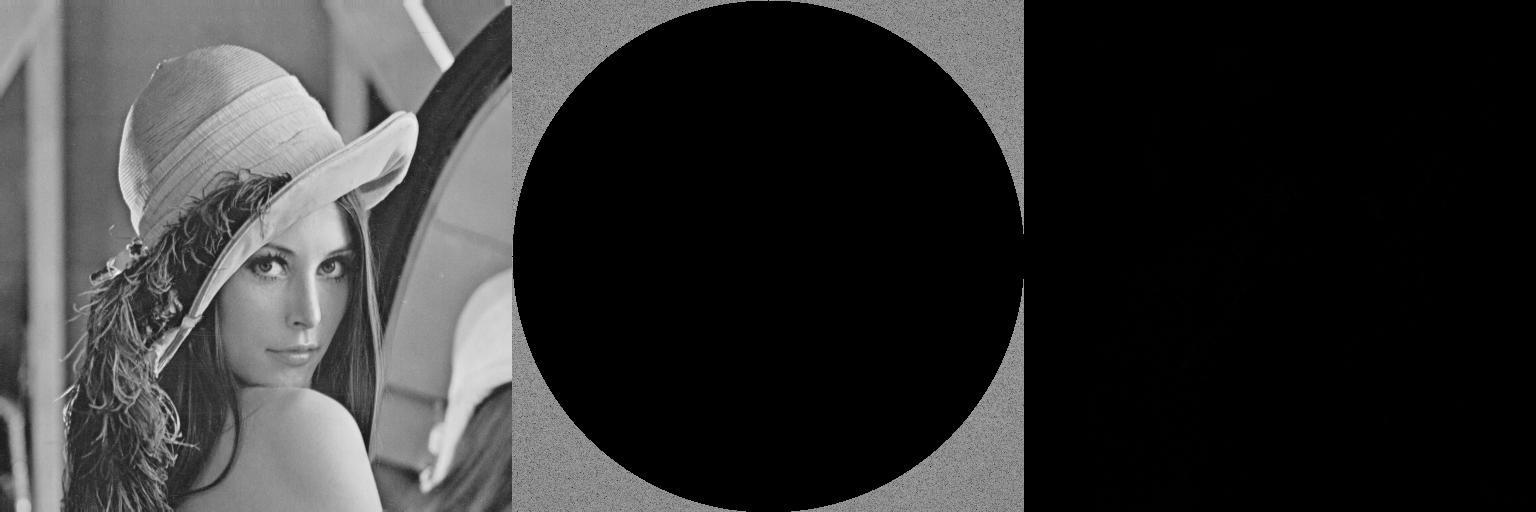

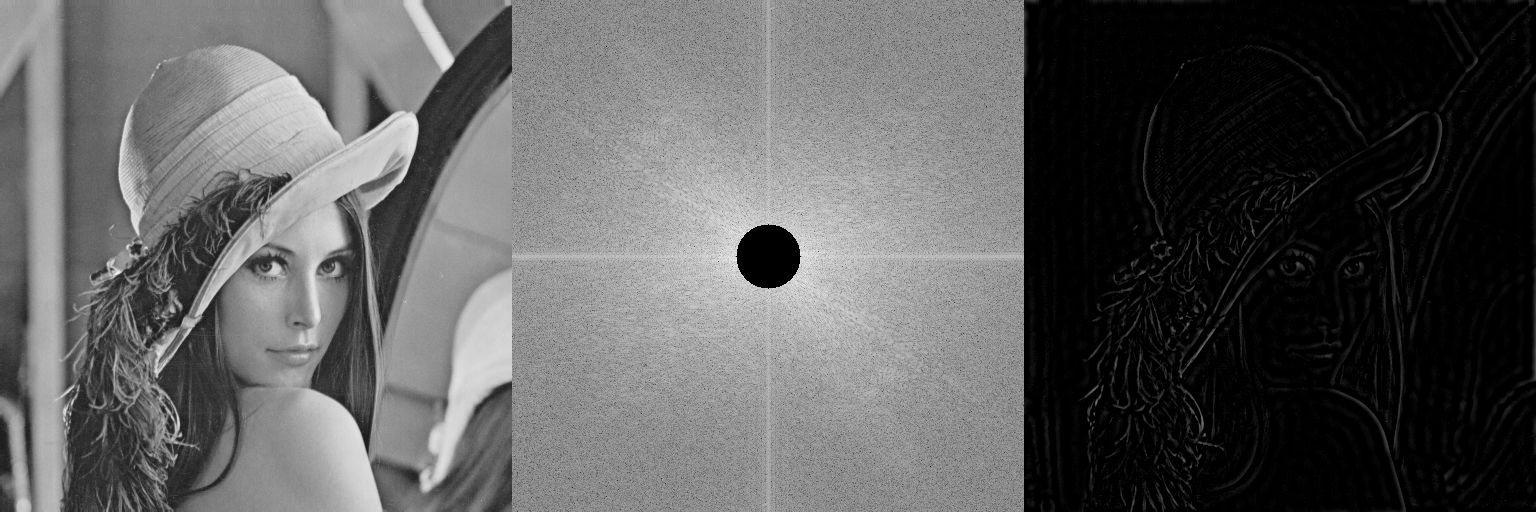

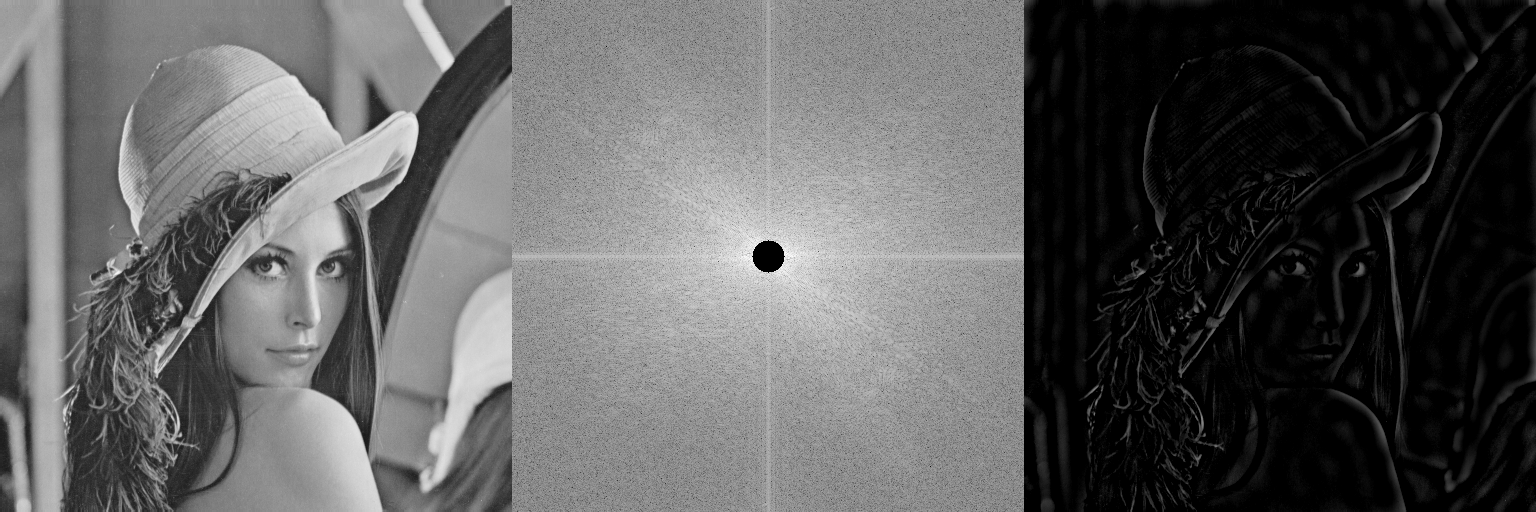

In [17]:
m1 = 1 - get_mask(img_grayscale.shape, 2)
m2 = 1 - get_mask(img_grayscale.shape, 16)
m3 = 1 - get_mask(img_grayscale.shape, 32)

fshift, spectrum = fft(img_grayscale)

img_back_1 = ifft(fshift * m1)
img_back_2 = ifft(fshift * m2)
img_back_3 = ifft(fshift * m3)

imshow(np.concatenate([img_grayscale, spectrum * m1, img_back_1], 1))
imshow(np.concatenate([img_grayscale, spectrum * m2, img_back_2], 1))
imshow(np.concatenate([img_grayscale, spectrum * m3, img_back_3], 1))

## Task 1

Check and argue which of the filters listed below is low pass and which is high pass.

Filters:
* averaging,
* gaussian,
* sobel,
* laplasjan

Answer:

* averaging - low-pass (since it smoothes the image),
* gaussian - low-pass (since it smoothes the image),
* sobel - high-pass (since it sharpens the image),
* laplasjan - high-pass (since it sharpens the image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


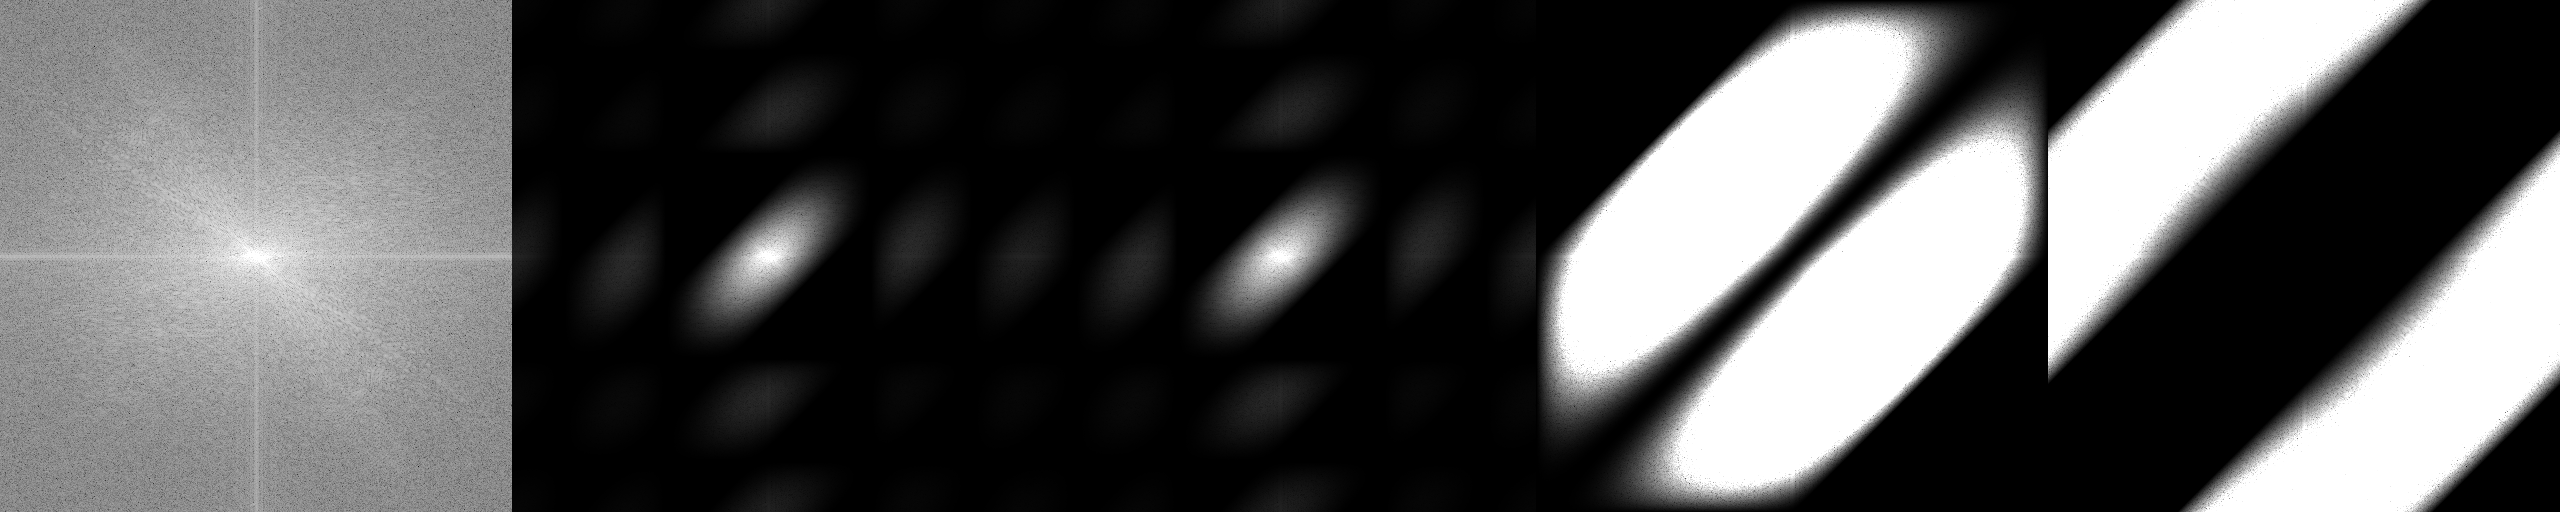

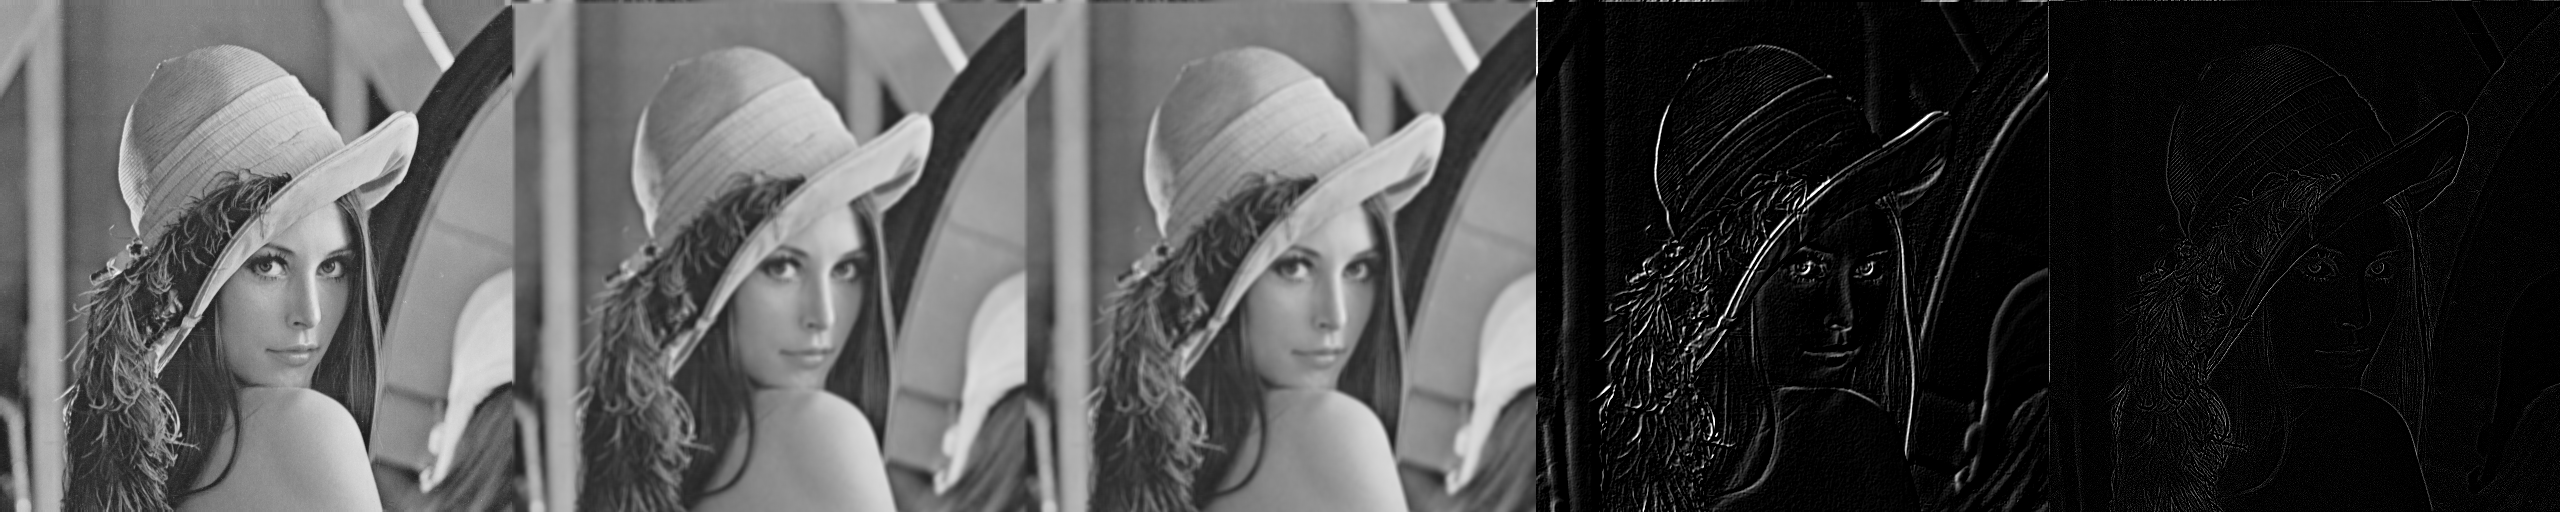

In [45]:
## cv2.addWeighted() implementation for combining sobel vertical and horizontal
def add_weighted(src1, alpha, src2, beta, y):
    return alpha * src1 + beta * src2 + y


horizontal_sobel = np.array([[1, 0, -1],
                             [2, 0, -2], 
                             [1, 0, -1]])

vertical_sobel = horizontal_sobel.T

img = img_grayscale.astype(float)
img_shift, spectrum = fft(img, (512, 512))

## averaging
mean_shift, mean_mag = fft(np.ones((5, 5)) / 25, (512, 512))

## gaussian
gaus_shift, gaus_mag = fft(gaussian, (512, 512))

## sobel
sob_vert_shift, sob_vert_mag = fft(vertical_sobel, (512, 512))
sob_hor_shift, sob_hor_mag = fft(horizontal_sobel, (512, 512))

## laplacian
lapl_shift, lapl_mag = fft(laplacian, (512, 512))


imshow(np.concatenate([spectrum, spectrum * mean_shift, spectrum * gaus_shift, spectrum * sob_vert_shift + spectrum * sob_hor_shift, spectrum * lapl_shift], 1))
imshow(np.concatenate([img, ifft(img_shift * mean_shift), ifft(img_shift * gaus_shift), add_weighted(ifft(img_shift * sob_hor_shift), 0.5, ifft(img_shift * sob_vert_shift), 0.5, 0), ifft(img_shift * lapl_shift)], 1))

## Task 2

Perform edge detection (vertically and horizontally separately) using Sobel's frequency domain filters, then combine the detected features into one image and present the results. Compare the frequency domain performance with the intensity domain performance .

Answer:

There are no major differences between frequency domain performance and intensity domain performance of the Sobel filter. However, they seem to "highlight" different range of frequences: high for vertical and low for horizantal frequency domain, and vice verca speaking of intensity domain.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


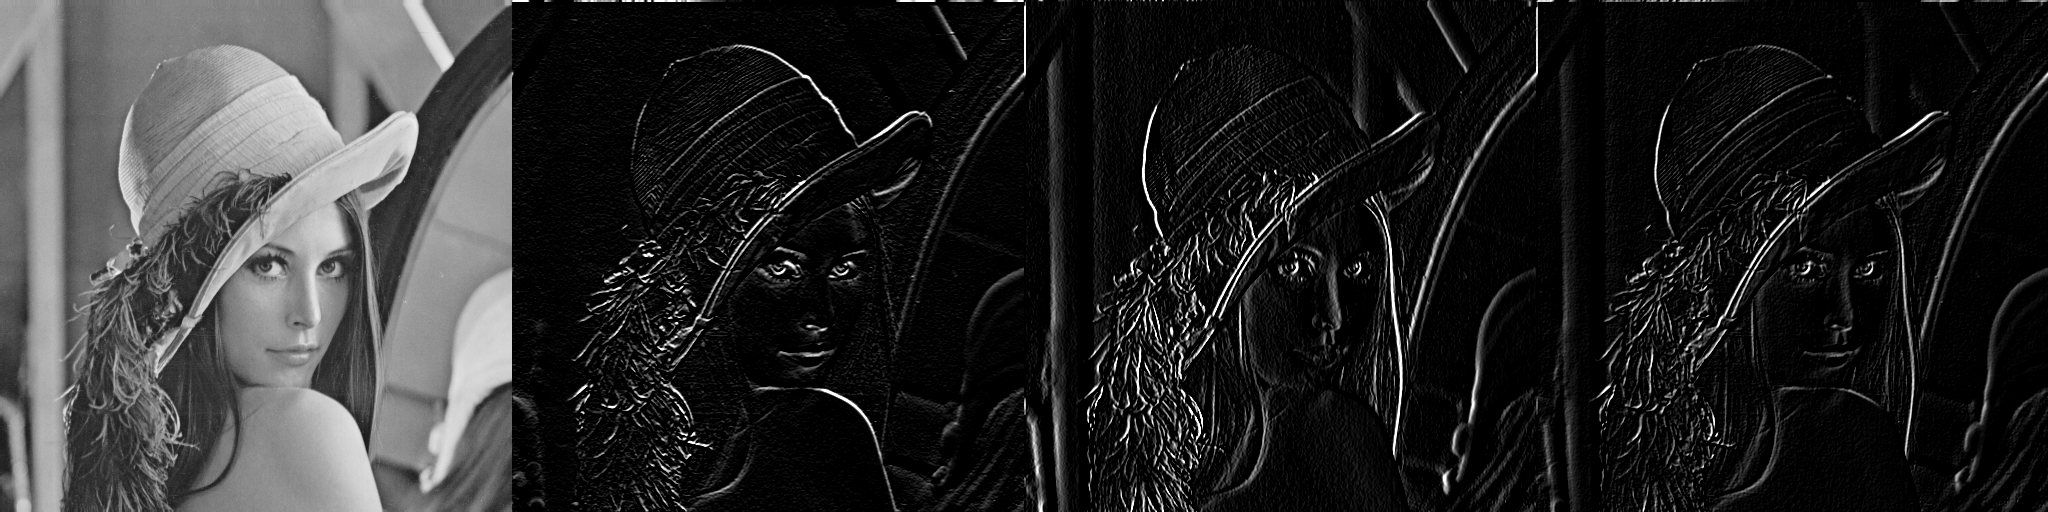

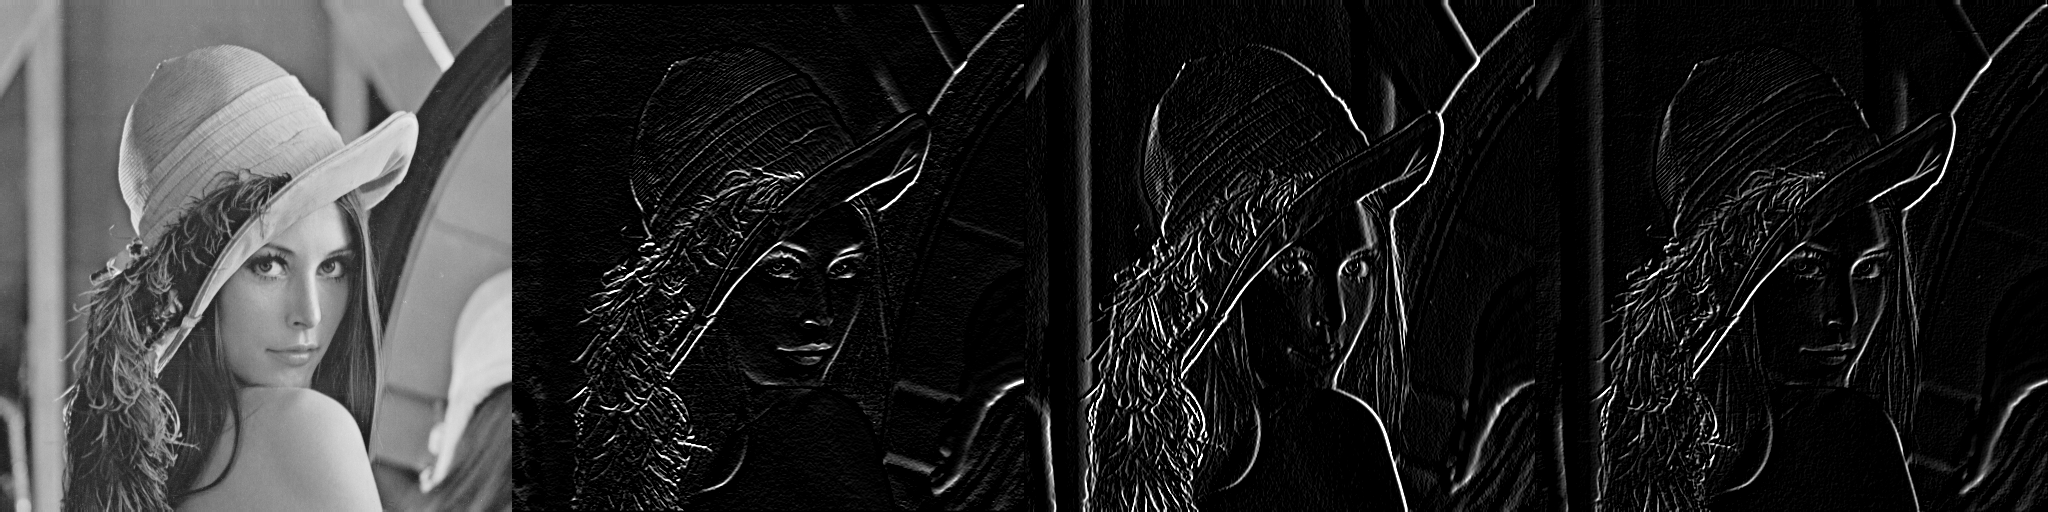

In [51]:
## Implementation of vertical and horizontal edge detection as well as it's combination can be also found in the solution to Task 1, copied for the sake of convenience

## cv2.addWeighted() implementation for combining sobel vertical and horizontal
def add_weighted(src1, alpha, src2, beta, y):
    return alpha * src1 + beta * src2 + y


horizontal_sobel = np.array([[1, 0, -1],
                             [2, 0, -2], 
                             [1, 0, -1]])

vertical_sobel = horizontal_sobel.T

sob_vert_shift, sob_vert_mag = fft(vertical_sobel, (512, 512))
sob_hor_shift, sob_hor_mag = fft(horizontal_sobel, (512, 512))

img = img_grayscale.astype(float)
img_shift, spectrum = fft(img, (512, 512))

# frequency domain
imshow(np.concatenate([img, ifft(img_shift * sob_vert_shift), ifft(img_shift * sob_hor_shift), add_weighted(ifft(img_shift * sob_hor_shift), 0.5, ifft(img_shift * sob_vert_shift), 0.5, 0)], 1))

# intensity domain
imshow(np.concatenate([img, cv2.filter2D(img, -1, vertical_sobel), cv2.filter2D(img, -1, horizontal_sobel), add_weighted(cv2.filter2D(img, -1, horizontal_sobel), 0.5, cv2.filter2D(img, -1, vertical_sobel), 0.5, 0)], 1))